## Data Processing

Begins with checking if my GPU is properly connected to tensorflow, as this will greatly impact the development time of the model.

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices() )
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Current device: {}".format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3912996520300776932
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14905280164728991661
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4922553139
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8370538739172644783
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3734930455175834959
physical_device_desc: "device: XLA_GPU device"
]
Num GPUs Available:  1
Current device: /device:GPU:0


### Importing Our Image Dataset
This data import assumes that this program and the dataset folder **leapGestRecog** lie in the same directory.

In [4]:
import cv2
import numpy as np
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

def get_images():
    """
    
    Uses cv2, os and numpy to loop through the folder 
    directories and import all images and their labels into numpy arrays X and Y.
    
    Output
    -----
    X: images
        type numpy.array
    Y: labels
        type numpy.array
        
    """
    
    base = 'leapGestRecog'
    if os.path.lexists(os.path.join(os.getcwd(), 'leapGestRecog')):
        directory = os.listdir(base)

    X = []
    Y =[]
    for item in directory:
        base = 'leapGestRecog'
        path =  base + '/' + item
        files = os.listdir(path)
        for file in files:
 
            next_path =  path + '/' + file
            image_paths = os.listdir(next_path)

            for image in image_paths:
                final_path = next_path + '/' + image
                img =cv2.imread(final_path, 0)
                img = cv2.resize(img, (320, 120))
                X.append(img)

                label = final_path.split('/')[2].split("_")[1]
             
                Y.append(label)
    X = np.array(X, dtype="uint8")
    X = X.reshape(len(X), 120, 320, 1) # Needed to reshape so CNN knows it's different images
    Y = np.array(Y)
    print("Images loaded: ", len(X))
    print("Labels loaded: ", len(Y))
    
    return X,Y


In [5]:
def process_Y(Y):
    class_names = list(np.unique(Y))
    for item in class_names:
        print(item, ": ", len(np.where(Y == item)[0]))
    for i,item in enumerate(Y):
        if item in class_names:
            Y[i] = int(class_names.index(item)) 
    Y =  np.array(Y, dtype="uint8")
    return class_names, Y

In [6]:
try:

    x_train =np.load("x_train.npy")
    y_train = np.load("y_train.npy")
    x_test = np.load("x_test.npy")
    y_test = np.load("y_test.npy")
    class_names = np.load("class_names.npy")
    print("Successfully loaded in the data WITH train-test split")
    
except:
    print("Failed to load pickled dataset WITH train-test split")
    
    try:
    
        X = np.load('images.npy')
        Y = np.load('labels.npy')
        class_names = np.load('class_names.npy')
        print("Loaded X (inputs) and Y (labels)")
        
    except:
        print("Failed to load pickled dataset WITHOUT train-test split")
        X,Y = get_images()
        class_names, Y = process_Y(Y)
        
        np.save("images.npy",X)
        np.save("labels.npy",Y)
        np.save("class_names.npy", class_names)
        print("Computed New X and Y values")


Successfully loaded in the data WITH train-test split


In [8]:
list(class_names), list(np.unique(y_train))

(['c', 'fist', 'index', 'l', 'ok', 'palm', 'thumb'], [0, 1, 2, 3, 4, 5, 6])

#### Checking the first element of our input array:

In [9]:
def split_the_data(X, Y):   
    
    X = X/255.0  ## normalize X array
    x_train, x_test = (X[:int(len(X)*0.8), ]), (X[int(len(X)*0.8):, ])
    y_train, y_test = (Y[:int(len(Y)*0.8), ]), (Y[int(len(Y)*0.8):, ])
    np.save("x_train.npy",x_train)
    np.save("y_train.npy",y_train)
    np.save("x_test.npy",x_test)
    np.save("y_test.npy",y_test)
    return x_train, x_test, y_train, y_test

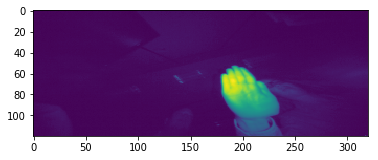

palm


In [10]:
def plot_image(image, label):
    image = image.reshape((120,320))
    plt.imshow(image)
    plt.show()
    print(label)

try:
    x_train, x_test, y_train, y_test = split_the_data(X, Y)
    del X,Y # delete X and Y from memory
    plot_image(x_train[0], class_names[y_train[0]])
except:
    try:
        plot_image(x_train[0],class_names[y_train[0]])
    except:
        pass

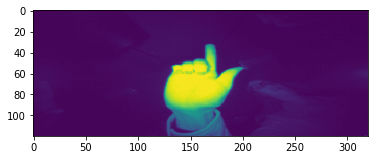

l


In [11]:
plot_image(x_train[200], class_names[y_train[200]])

In [12]:
#x_train, x_test = tf.convert_to_tensor(x_train), tf.convert_to_tensor(x_test)
#y_train, y_test = tf.convert_to_tensor(y_train), tf.convert_to_tensor(y_test) 
x_train.shape, y_train.shape,  x_test.shape, y_test.shape

((11200, 120, 320, 1), (11200,), (2800, 120, 320, 1), (2800,))

In [13]:
from tensorflow.keras import datasets, layers, models

In [14]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (50, 50), activation='relu', input_shape=(120, 320, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (25, 25), activation='relu', kernel_regularizer='l2'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((3, 3)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(7))

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'] )
    return model

In [19]:
def fit(model, epochs):
    history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs=epochs, verbose = 1)
    return history

In [20]:
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt".format(epoch = 300)
model = build_model()
history = fit(model, 300)

Epoch 1/300
350/350 [==============================] - 67s 192ms/step - loss: 0.8545 - accuracy: 0.8500 - val_loss: 1.7197 - val_accuracy: 0.6343
Epoch 2/300
350/350 [==============================] - 67s 192ms/step - loss: 0.2440 - accuracy: 0.9852 - val_loss: 2.1507 - val_accuracy: 0.7221
Epoch 3/300
350/350 [==============================] - 68s 194ms/step - loss: 0.2011 - accuracy: 0.9845 - val_loss: 1.6619 - val_accuracy: 0.6614
Epoch 4/300
350/350 [==============================] - 68s 194ms/step - loss: 0.1728 - accuracy: 0.9877 - val_loss: 1.8017 - val_accuracy: 0.7521
Epoch 5/300
350/350 [==============================] - 68s 194ms/step - loss: 0.1285 - accuracy: 0.9906 - val_loss: 1.7148 - val_accuracy: 0.7039
Epoch 6/300
350/350 [==============================] - 69s 196ms/step - loss: 0.1448 - accuracy: 0.9898 - val_loss: 1.4180 - val_accuracy: 0.7546
Epoch 7/300
350/350 [==============================] - 73s 207ms/step - loss: 0.1486 - accuracy: 0.9894 - val_loss: 1.4134 -

350/350 [==============================] - 87s 247ms/step - loss: 0.0971 - accuracy: 0.9960 - val_loss: 1.8611 - val_accuracy: 0.7486
Epoch 56/300
350/350 [==============================] - 86s 247ms/step - loss: 0.0818 - accuracy: 0.9956 - val_loss: 1.8083 - val_accuracy: 0.6900
Epoch 57/300
350/350 [==============================] - 85s 243ms/step - loss: 0.0945 - accuracy: 0.9953 - val_loss: 1.3225 - val_accuracy: 0.7504
Epoch 58/300
350/350 [==============================] - 85s 244ms/step - loss: 0.1087 - accuracy: 0.9935 - val_loss: 2.3603 - val_accuracy: 0.6321
Epoch 59/300
350/350 [==============================] - 86s 245ms/step - loss: 0.1091 - accuracy: 0.9965 - val_loss: 2.6844 - val_accuracy: 0.7471
Epoch 60/300
350/350 [==============================] - 86s 246ms/step - loss: 0.1294 - accuracy: 0.9924 - val_loss: 2.5814 - val_accuracy: 0.7132
Epoch 61/300
350/350 [==============================] - 87s 247ms/step - loss: 0.0905 - accuracy: 0.9965 - val_loss: 1.6606 - val_a

Epoch 111/300
350/350 [==============================] - 83s 236ms/step - loss: 0.1146 - accuracy: 0.9901 - val_loss: 1.7450 - val_accuracy: 0.7979
Epoch 112/300
350/350 [==============================] - 81s 232ms/step - loss: 0.0730 - accuracy: 0.9987 - val_loss: 1.7561 - val_accuracy: 0.7668
Epoch 113/300
350/350 [==============================] - 82s 235ms/step - loss: 0.0874 - accuracy: 0.9946 - val_loss: 1.6025 - val_accuracy: 0.8021
Epoch 114/300
350/350 [==============================] - 81s 233ms/step - loss: 0.0523 - accuracy: 0.9990 - val_loss: 1.6017 - val_accuracy: 0.7475
Epoch 115/300
350/350 [==============================] - 83s 236ms/step - loss: 0.0806 - accuracy: 0.9952 - val_loss: 1.8692 - val_accuracy: 0.7068
Epoch 116/300
350/350 [==============================] - 81s 232ms/step - loss: 0.0963 - accuracy: 0.9941 - val_loss: 1.0796 - val_accuracy: 0.7929
Epoch 117/300
350/350 [==============================] - 83s 236ms/step - loss: 0.0509 - accuracy: 0.9986 - val_

KeyboardInterrupt: 

In [ ]:
model.save('saved_model/my_model') 

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig("saved_accuracy.png")
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.savefig("saved_loss.png")

In [ ]:
output = model.predict(x_test[0:1000])
model.predict(x_test[0:1])

In [ ]:
class_names = np.unique(y_train)
classes = ['c',
  'down',
  'fist',
  'fistmoved',
  'index',
  'l',
  'ok',
  'palm',
  'palmmoved',
  'thumb']

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,4))
plt.bar(class_names, output[500])
#plt.ylim(0, output[0].max())
plt.show()

In [ ]:
plt.imshow(x_test[500].reshape((120,320)))
print("We predict: {}".format(classes[np.argmax(output)]))
print("True value: {}".format(classes[y_test[500]]))